In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff
import gc # 메모리 제어 gc.collet()
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
tqdm.pandas()

### ▶메모리

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
trans_cat_cols = ["ProductCD","card1","card2","card3","card4","card5","card6","addr1","addr2","P_emaildomain_bin","P_emaildomain_suffix",
                   "R_emaildomain_bin","R_emaildomain_suffix","M1","M2","M3","M4","M5","M6","M7","M8","M9"]

iden_cat_cols = ["DeviceType","DeviceInfo","id_12",
                   "id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22","id_23","id_24",
                   "id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32","id_33","id_34","id_35","id_36",
                   "id_37","id_38"]

In [5]:
def transform_transaction_catcols(df1, df2):
    for cat_col in tqdm( trans_cat_cols): 
        # Get the indices for NaN values
        trn_null_ind = [ind for ind, val in enumerate(df1[cat_col].isnull().values) if val == True]
        ts_null_ind = [ind for ind, val in enumerate(df2[cat_col].isnull().values) if val == True]
        
        uniq_train_cat_val , uniq_test_cat_val = set(df1[cat_col].dropna() ), set(df2[cat_col].dropna() )
        common_cat_val = uniq_train_cat_val.intersection(uniq_test_cat_val)
        df1.loc[ ~df1[cat_col].isin( common_cat_val), cat_col ] = -99999
        df2.loc[ ~df2[cat_col].isin( common_cat_val), cat_col ] = -99999
        
        # Replace the value for orignal NaN values
        df1.loc[df1.index.isin(trn_null_ind), cat_col] = np.NaN
        df2.loc[df2.index.isin(ts_null_ind), cat_col] = np.NaN
        
    del uniq_train_cat_val, uniq_test_cat_val, common_cat_val; gc.collect()
    
    # Reduce the usage of memory
    df1 = reduce_mem_usage(df1)
    df2 = reduce_mem_usage(df2)
    
    return df1, df2

def transform_identity_catcols(df1,df2):
    for cat_col in tqdm( iden_cat_cols ): 
        
        # Get the indices for NaN values
        trn_null_ind = [ind for ind, val in enumerate(df1[cat_col].isnull().values) if val == True]
        ts_null_ind = [ind for ind, val in enumerate(df2[cat_col].isnull().values) if val == True]
        
        uniq_train_cat_val , uniq_test_cat_val = set(df1[cat_col].dropna() ), set(df2[cat_col].dropna() )
        common_cat_val = uniq_train_cat_val.intersection(uniq_test_cat_val)
        df1.loc[ ~df1[cat_col].isin( common_cat_val), cat_col ] = -99999
        df2.loc[ ~df2[cat_col].isin( common_cat_val), cat_col ] = -99999
        
        # Replace the value for orignal NaN values
        df1.loc[df1.index.isin(trn_null_ind), cat_col] =  np.NaN
        df2.loc[df2.index.isin(ts_null_ind), cat_col] =  np.NaN
        
        
    del uniq_train_cat_val, uniq_test_cat_val, common_cat_val; gc.collect();
    
    # Reduce the usage of memory
    df1 = reduce_mem_usage(df1)
    df2 = reduce_mem_usage(df2)
    
    return df1, df2

#### ex) 메모리

In [52]:
train_trans['card2'].isnull().values

array([ True, False, False, ..., False, False, False])

In [53]:
[ind for ind, val in enumerate(train_trans['card2'].isnull().values) if val]

[0,
 123,
 135,
 213,
 223,
 360,
 375,
 388,
 436,
 447,
 450,
 494,
 509,
 569,
 661,
 663,
 675,
 736,
 753,
 768,
 794,
 834,
 874,
 880,
 892,
 894,
 1005,
 1010,
 1067,
 1166,
 1245,
 1264,
 1281,
 1417,
 1501,
 1515,
 1871,
 1913,
 1957,
 1959,
 1975,
 2074,
 2104,
 2137,
 2139,
 2413,
 2434,
 2459,
 2645,
 2703,
 2711,
 3085,
 3199,
 3225,
 3266,
 3310,
 3481,
 3650,
 3673,
 3881,
 3907,
 3908,
 3919,
 3977,
 3984,
 3991,
 4023,
 4090,
 4095,
 4156,
 4543,
 4656,
 4756,
 4880,
 4908,
 5073,
 5098,
 5411,
 5455,
 5510,
 5618,
 6018,
 6229,
 6274,
 6279,
 6307,
 6469,
 6773,
 6796,
 6905,
 7131,
 7136,
 7463,
 7504,
 7696,
 7769,
 7807,
 8397,
 8416,
 8428,
 8440,
 8506,
 8539,
 8759,
 8854,
 8863,
 9015,
 9153,
 9206,
 9291,
 9423,
 9558,
 9561,
 9600,
 9686,
 9740,
 9846,
 9919,
 9996,
 10048,
 10143,
 10264,
 10336,
 10605,
 10610,
 10694,
 10723,
 10758,
 10806,
 10871,
 10990,
 11003,
 11382,
 11400,
 11495,
 11689,
 12289,
 12507,
 12542,
 12669,
 12687,
 12748,
 12765,
 12

In [25]:
train_trans['card2'].dropna()

1         404.0
2         490.0
3         567.0
4         514.0
5         555.0
          ...  
590534    408.0
590536    225.0
590537    595.0
590538    481.0
590539    170.0
Name: card2, Length: 581607, dtype: float64

### ▶ 데이터 로드

In [11]:
train_idf = pd.read_csv('./data/train_identity.csv')
train_trans = pd.read_csv('./data/train_transaction.csv')
test_idf = pd.read_csv('./data/test_identity.csv')
test_trans = pd.read_csv('./data/test_transaction.csv')

In [12]:
train_idf.shape, train_trans.shape, test_idf.shape, test_trans.shape

((144233, 41), (590540, 394), (141907, 41), (506691, 393))

In [27]:
v_cols = [ c for c in train_trans.columns if c[0]=='V']

In [40]:
train_trans[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
len(train_trans[train_trans['isFraud']==0])/len(train_trans)

0.9650099908558268

In [19]:
1-0.9650099908558268

0.03499000914417316

In [11]:
def email_categorical_expression(emails):
    """
    Get the type of email
    (1) Both "P_emaildomain" & "R_emaildomain" are None
    (2) "P_emaildomain" is None, but "R_emaildomain" isn't None
    (3) "P_emaildomain" isn't None, but "R_emaildomain" is None
    (4) Both "P_emaildomain" & "R_emaildomain" aren't None
    """
    P_emaildomain, R_emaildomain = emails

    if type(P_emaildomain) ==  float:
        if type(R_emaildomain) == float:
            email_type = 1
        else:
            email_type = 2
    else:
        if type(R_emaildomain) == float:
            email_type = 3
        else:
            email_type = 4
    return email_type    
    
def email_null_concat(emails):
    """
    Get the row-wise concat of email_address
    """
    temp = emails.isnull().astype(np.int8)
    label= ''
    for col in ['P_emaildomain','R_emaildomain']:
        label += str(temp[col] ) +'_'
    return label

In [12]:
train_trans['email_type'] = train_trans[['P_emaildomain', 'R_emaildomain']].progress_apply(lambda x : email_categorical_expression(x) , axis=1)
train_trans['email_null_concat'] = train_trans[['P_emaildomain', 'R_emaildomain']].progress_apply(lambda x : email_null_concat(x) , axis=1)

test_trans['email_type'] = test_trans[['P_emaildomain', 'R_emaildomain']].progress_apply(lambda x : email_categorical_expression(x) , axis=1)
test_trans['email_null_concat'] = test_trans[['P_emaildomain', 'R_emaildomain']].progress_apply(lambda x : email_null_concat(x) , axis=1)

  0%|          | 0/590540 [00:00<?, ?it/s]

  0%|          | 0/590540 [00:00<?, ?it/s]

  0%|          | 0/506691 [00:00<?, ?it/s]

  0%|          | 0/506691 [00:00<?, ?it/s]

In [27]:
# !jupyter labextension list

JupyterLab v4.0.11
C:\Users\USER\anaconda3\share\jupyter\labextensions
        jupyterlab-plotly v5.22.0 enabled  X
        @anaconda/assistant v4.0.15 enabled ok (python, aext_assistant)
        @anaconda/core v4.0.15 enabled ok (python, aext_core)
        @anaconda/panels v4.0.15 enabled ok (python, aext_panels)
        @anaconda/share_notebook v4.0.15 enabled ok (python, aext_share_notebook)
        @jupyter-notebook/lab-extension v7.0.8 enabled ok
        @jupyter-widgets/jupyterlab-manager v5.0.11 enabled ok (python, jupyterlab_widgets)
        @lckr/jupyterlab_variableinspector v3.1.0 enabled ok (python, lckr_jupyterlab_variableinspector)
        @pyviz/jupyterlab_pyviz v3.0.2 enabled ok


   The following extensions are outdated:
        jupyterlab-plotly
        
   Consider checking if an update is available for these packages.



#### ex) 이메일

In [56]:
train_trans['P_emaildomain']

0                 NaN
1           gmail.com
2         outlook.com
3           yahoo.com
4           gmail.com
             ...     
590535            NaN
590536      gmail.com
590537      gmail.com
590538        aol.com
590539      gmail.com
Name: P_emaildomain, Length: 590540, dtype: object

In [26]:
train_trans['P_emaildomain'].str.split('.').str[-1].unique()

array([nan, 'com', 'net', 'mx', 'gmail', 'es', 'de', 'fr', 'uk', 'jp'],
      dtype=object)

In [41]:
train_trans[~train_trans['R_emaildomain'].isnull()]['R_emaildomain']

10            gmail.com
11          hotmail.com
38            gmail.com
40            gmail.com
48          outlook.com
              ...      
590521         yahoo.fr
590526        gmail.com
590529        gmail.com
590531    anonymous.com
590534        gmail.com
Name: R_emaildomain, Length: 137291, dtype: object

In [51]:
train_trans[['P_emaildomain', 'R_emaildomain']][:10].progress_apply(
    lambda x : email_categorical_expression(x) ,
    axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 572.15it/s]

P_emaildomain    NaN
R_emaildomain    NaN
Name: 0, dtype: object
email_type 1
P_emaildomain    gmail.com
R_emaildomain          NaN
Name: 1, dtype: object
email_type 3
P_emaildomain    outlook.com
R_emaildomain            NaN
Name: 2, dtype: object
email_type 3
P_emaildomain    yahoo.com
R_emaildomain          NaN
Name: 3, dtype: object
email_type 3
P_emaildomain    gmail.com
R_emaildomain          NaN
Name: 4, dtype: object
email_type 3
P_emaildomain    gmail.com
R_emaildomain          NaN
Name: 5, dtype: object
email_type 3
P_emaildomain    yahoo.com
R_emaildomain          NaN
Name: 6, dtype: object
email_type 3
P_emaildomain    mail.com
R_emaildomain         NaN
Name: 7, dtype: object
email_type 3
P_emaildomain    anonymous.com
R_emaildomain              NaN
Name: 8, dtype: object
email_type 3
P_emaildomain    yahoo.com
R_emaildomain          NaN
Name: 9, dtype: object
email_type 3


0    1
1    3
2    3
3    3
4    3
5    3
6    3
7    3
8    3
9    3
dtype: int64

In [54]:
train_trans[['P_emaildomain', 'R_emaildomain']][:10].progress_apply(
    lambda x : email_null_concat(x) , axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 840.66it/s]

P_emaildomain    True
R_emaildomain    True
Name: 0, dtype: bool
label 1_1_
P_emaildomain    False
R_emaildomain     True
Name: 1, dtype: bool
label 0_1_
P_emaildomain    False
R_emaildomain     True
Name: 2, dtype: bool
label 0_1_
P_emaildomain    False
R_emaildomain     True
Name: 3, dtype: bool
label 0_1_
P_emaildomain    False
R_emaildomain     True
Name: 4, dtype: bool
label 0_1_
P_emaildomain    False
R_emaildomain     True
Name: 5, dtype: bool
label 0_1_
P_emaildomain    False
R_emaildomain     True
Name: 6, dtype: bool
label 0_1_
P_emaildomain    False
R_emaildomain     True
Name: 7, dtype: bool
label 0_1_
P_emaildomain    False
R_emaildomain     True
Name: 8, dtype: bool
label 0_1_
P_emaildomain    False
R_emaildomain     True
Name: 9, dtype: bool
label 0_1_


0    1_1_
1    0_1_
2    0_1_
3    0_1_
4    0_1_
5    0_1_
6    0_1_
7    0_1_
8    0_1_
9    0_1_
dtype: object

### ▶ email preprocessing 

In [13]:
# email preprocessing 
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [14]:
emaildomain = ['P_emaildomain', 'R_emaildomain']
for c in emaildomain:
    train_trans[c + '_bin'] = train_trans[c].map(emails)
    test_trans[c + '_bin'] = test_trans[c].map(emails)
    
    train_trans[c + '_suffix'] = train_trans[c].map(lambda x: str(x).split('.')[-1])
    test_trans[c + '_suffix'] = test_trans[c].map(lambda x: str(x).split('.')[-1])
    
    train_trans[c + '_suffix'] = train_trans[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_trans[c + '_suffix'] = test_trans[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

### ▶ m_cols

In [15]:
m_cols = [c for c in list(train_trans) if 'M' == c[0]]

In [16]:
# Use "M_cols" information
train_m = train_trans[['TransactionID'] + m_cols]
test_m = test_trans[['TransactionID'] + m_cols]

# Combination of all "M" columns
train_m['m_comb'] = ''
test_m['m_comb'] = ''
for col in m_cols:
    train_m['m_comb'] += train_m[col].astype(str) +'_' 
    test_m['m_comb'] += test_m[col].astype(str) +'_' 

# If the combination is not in the common value, replace those into "Unknown"
unique_trn_m_comb = np.unique(  train_m['m_comb'] )
unique_ts_m_comb  = np.unique(  test_m['m_comb'] )
common_m_comb = np.intersect1d( unique_trn_m_comb , unique_ts_m_comb )

train_m.loc[~train_m['m_comb'].isin(common_m_comb), 'm_comb'] = 'Unknown'
test_m.loc[~test_m['m_comb'].isin(common_m_comb), 'm_comb'] = 'Unknown'

# Sum of the null value for all "M" columns & "# of True value"
train_m['m_null_sum'] = train_m[m_cols].isnull().sum(axis=1)
train_m['m_T_sum'] = (train_m[m_cols]=='T').sum(axis=1)
test_m['m_null_sum'] = test_m[m_cols].isnull().sum(axis=1)
test_m['m_T_sum'] = (test_m[m_cols]=='T').sum(axis=1)

# Label Encoding columns related with 'M':
# 'm_comb' + m_cols
lbl = LabelEncoder()

# for col in tqdm( m_cols + ['m_comb'] ):
for col in tqdm( m_cols+['m_comb'] ):
    lbl.fit( train_m[col].fillna('Unknown') )
    train_m[col] = lbl.transform( train_m[col].fillna('Unknown')  ).astype(np.int8)
    test_m[col] = lbl.transform( test_m[col].fillna('Unknown')  ).astype(np.int8)
    
train_m = train_m[['TransactionID', 'm_comb','m_null_sum','m_T_sum']]
test_m = test_m[['TransactionID', 'm_comb','m_null_sum','m_T_sum']]

print(train_m)

train_trans = train_trans.merge(train_m, on ='TransactionID', how='left')
test_trans = test_trans.merge(test_m, on ='TransactionID', how='left')

  0%|          | 0/10 [00:00<?, ?it/s]

        TransactionID  m_comb  m_null_sum  m_T_sum
0             2987000     112           3        4
1             2987001     -97           6        2
2             2987002      -4           0        3
3             2987003     -98           6        1
4             2987004     -63           9        0
...               ...     ...         ...      ...
590535        3577535      19           0        5
590536        3577536      13           0        2
590537        3577537     122           5        2
590538        3577538      11           3        4
590539        3577539     116           2        2

[590540 rows x 4 columns]


#### ex) m_cols

In [14]:
m_cols = [c for c in list(train_trans) if 'M' == c[0]]

In [15]:
train_trans[m_cols]

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,T,T,T,M0,F,T,NaN,NaN,NaN


In [14]:
train_trans[['TransactionID'] + m_cols].head()

,TransactionID,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,T,T,T,M2,F,T,NaN,NaN,NaN
1,2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2987002,T,T,T,M0,F,F,F,F,F
3,2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
train_m

,TransactionID,m_comb,m_null_sum,m_T_sum
0,2987000,112,3,4
1,2987001,-97,6,2
2,2987002,-4,0,3
3,2987003,-98,6,1
4,2987004,-63,9,0
...,...,...,...,...
590535,3577535,19,0,5
590536,3577536,13,0,2
590537,3577537,122,5,2
590538,3577538,11,3,4


In [16]:
train_mm = train_trans[['TransactionID'] + m_cols]
test_mm = test_trans[['TransactionID'] + m_cols]

train_mm['m_comb'] = ''
test_mm['m_comb'] = ''
for col in m_cols:
    train_mm['m_comb'] += train_mm[col].astype(str) +'_' 
    test_mm['m_comb'] += test_mm[col].astype(str) +'_' 

In [20]:
train_mm

,TransactionID,M1,M2,M3,M4,M5,M6,M7,M8,M9,m_comb
0,2987000,T,T,T,M2,F,T,NaN,NaN,NaN,T_T_T_M2_F_T_nan_nan_nan_
1,2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,nan_nan_nan_M0_T_T_nan_nan_nan_
2,2987002,T,T,T,M0,F,F,F,F,F,T_T_T_M0_F_F_F_F_F_
3,2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,nan_nan_nan_M0_T_F_nan_nan_nan_
4,2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan_nan_nan_nan_nan_nan_nan_nan_nan_
...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,T,T,T,M0,T,F,F,F,T,T_T_T_M0_T_F_F_F_T_
590536,3577536,T,F,F,M0,F,T,F,F,F,T_F_F_M0_F_T_F_F_F_
590537,3577537,T,F,F,NaN,NaN,T,NaN,NaN,NaN,T_F_F_nan_nan_T_nan_nan_nan_
590538,3577538,T,T,T,M0,F,T,NaN,NaN,NaN,T_T_T_M0_F_T_nan_nan_nan_


In [17]:
unique_trn_mm_comb = np.unique(train_mm['m_comb'])
unique_ts_mm_comb = np.unique(test_mm['m_comb'])
common_mm_comb = np.intersect1d(unique_trn_mm_comb, unique_ts_mm_comb)

train_mm.loc[~train_mm['m_comb'].isin(common_mm_comb), 'm_comb'] = 'Unknown'
test_mm.loc[~test_mm['m_comb'].isin(common_mm_comb), 'm_comb'] = 'Unknown'

In [18]:
train_mm[train_mm['m_comb']=='Unknown']

,TransactionID,M1,M2,M3,M4,M5,M6,M7,M8,M9,m_comb
4111,2991111,T,T,F,M0,F,F,F,T,F,Unknown
9862,2996862,T,T,F,M1,T,NaN,F,F,F,Unknown
11888,2998888,T,T,F,M2,T,NaN,F,T,T,Unknown
11898,2998898,T,T,F,M2,T,NaN,F,T,T,Unknown
22881,3009881,T,T,F,M2,T,NaN,F,T,T,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
563467,3550467,NaN,NaN,NaN,NaN,NaN,T,F,T,T,Unknown
563471,3550471,NaN,NaN,NaN,NaN,NaN,T,F,T,T,Unknown
569860,3556860,T,T,T,M1,NaN,T,F,F,F,Unknown
571147,3558147,T,T,F,M2,F,T,T,T,T,Unknown


In [19]:
train_mm['m_null_sum'] = train_mm[m_cols].isnull().sum(axis=1)
test_mm['m_null_sum'] = test_mm[m_cols].isnull().sum(axis=1)

In [20]:
train_mm

,TransactionID,M1,M2,M3,M4,M5,M6,M7,M8,M9,m_comb,m_null_sum
0,2987000,T,T,T,M2,F,T,NaN,NaN,NaN,T_T_T_M2_F_T_nan_nan_nan_,3
1,2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,nan_nan_nan_M0_T_T_nan_nan_nan_,6
2,2987002,T,T,T,M0,F,F,F,F,F,T_T_T_M0_F_F_F_F_F_,0
3,2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,nan_nan_nan_M0_T_F_nan_nan_nan_,6
4,2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan_nan_nan_nan_nan_nan_nan_nan_nan_,9
...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,T,T,T,M0,T,F,F,F,T,T_T_T_M0_T_F_F_F_T_,0
590536,3577536,T,F,F,M0,F,T,F,F,F,T_F_F_M0_F_T_F_F_F_,0
590537,3577537,T,F,F,NaN,NaN,T,NaN,NaN,NaN,T_F_F_nan_nan_T_nan_nan_nan_,5
590538,3577538,T,T,T,M0,F,T,NaN,NaN,NaN,T_T_T_M0_F_T_nan_nan_nan_,3


In [21]:
# 각 데이터프레임에 'm_T_sum'이라는 새로운 열을 추가합니다. 이 열에는 "M"로 시작하는 열들에 대해 값이 'T'인 경우의 합계가 저장됩니다.
train_mm['m_T_sum'] = (train_mm[m_cols]=='T').sum(axis=1)
test_mm['m_T_sum'] = (test_mm[m_cols]=='T').sum(axis=1)

In [22]:
train_mm

,TransactionID,M1,M2,M3,M4,M5,M6,M7,M8,M9,m_comb,m_null_sum,m_T_sum
0,2987000,T,T,T,M2,F,T,NaN,NaN,NaN,T_T_T_M2_F_T_nan_nan_nan_,3,4
1,2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,nan_nan_nan_M0_T_T_nan_nan_nan_,6,2
2,2987002,T,T,T,M0,F,F,F,F,F,T_T_T_M0_F_F_F_F_F_,0,3
3,2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,nan_nan_nan_M0_T_F_nan_nan_nan_,6,1
4,2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan_nan_nan_nan_nan_nan_nan_nan_nan_,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,T,T,T,M0,T,F,F,F,T,T_T_T_M0_T_F_F_F_T_,0,5
590536,3577536,T,F,F,M0,F,T,F,F,F,T_F_F_M0_F_T_F_F_F_,0,2
590537,3577537,T,F,F,NaN,NaN,T,NaN,NaN,NaN,T_F_F_nan_nan_T_nan_nan_nan_,5,2
590538,3577538,T,T,T,M0,F,T,NaN,NaN,NaN,T_T_T_M0_F_T_nan_nan_nan_,3,4


In [ ]:
lbl = LabelEncoder()

for col in tqdm( m_cols + ['m_comb'] ):
    print(col)
    lbl.fit( train_mm[col].fillna('Unknown') )
    print(lbl.transform( train_mm[col].fillna('Unknown')))
    train_mm[col] = lbl.transform( train_mm[col].fillna('Unknown')  ).astype(np.int8)
    test_mm[col] = lbl.transform( test_mm[col].fillna('Unknown')  ).astype(np.int8)

In [26]:
train_mm = train_mm[['TransactionID', 'm_comb','m_null_sum','m_T_sum']]
# test_m = test_m[['TransactionID', 'm_comb','m_null_sum','m_T_sum']]

train_trans = train_trans.merge(train_mm, on ='TransactionID', how='left')
# test_trans = test_trans.merge(test_m, on ='TransactionID', how='left')

In [27]:
train_mm

,TransactionID,m_comb,m_null_sum,m_T_sum
0,2987000,-16,3,4
1,2987001,31,6,2
2,2987002,124,0,3
3,2987003,30,6,1
4,2987004,65,9,0
...,...,...,...,...
590535,3577535,-109,0,5
590536,3577536,-115,0,2
590537,3577537,-6,5,2
590538,3577538,-117,3,4


In [28]:
train_trans

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,m_comb_x,m_null_sum_x,m_T_sum_x,m_comb_y,m_null_sum_y,m_T_sum_y
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,nan,NaN,nan,112,3,4,-16,3,4
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,google,com,NaN,nan,-97,6,2,31,6,2
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,microsoft,com,NaN,nan,-4,0,3,124,0,3
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,yahoo,com,NaN,nan,-98,6,1,30,6,1
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,google,com,NaN,nan,-63,9,0,65,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,nan,NaN,nan,19,0,5,-109,0,5
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,google,com,NaN,nan,13,0,2,-115,0,2
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,google,com,NaN,nan,122,5,2,-6,5,2
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,aol,com,NaN,nan,11,3,4,-117,3,4


### ▶ date

In [55]:
df = train_trans

In [33]:
len(train_trans['D1'].unique())

642

In [35]:
train_trans['D1'].describe()

count    589271.000000
mean         94.347568
std         157.660387
min           0.000000
25%           0.000000
50%           3.000000
75%         122.000000
max         640.000000
Name: D1, dtype: float64

In [59]:
df['D1n'] = np.floor(df['TransactionDT']/(24*60*60))-df['D1']
df['uid'] = df['card1'].astype(str)+'_'+df['addr1'].astype(str)+'_'+df['D1n'].astype(str)

In [63]:
len(df['uid'].unique())

217850

In [ ]:
df['']

In [17]:
import datetime 
# import ipywidgets as widgets
# widgets.IntSlider()

start_date = datetime.datetime.strptime('2017.11.30', '%Y.%m.%d')
train_trans['timeblock'] = train_trans['TransactionDT'].apply(lambda x: 
                                                              datetime.timedelta(seconds = x) + start_date ) 
test_trans['timeblock'] = test_trans['TransactionDT'].apply(lambda x:
                                                            datetime.timedelta(seconds = x) + start_date ) 

tb = train_trans['timeblock']
train_trans.drop('timeblock', axis=1, inplace=True)
train_trans.insert(0, 'timeblock', tb)

tb = test_trans['timeblock']
test_trans.drop('timeblock', axis=1, inplace=True)
test_trans.insert(0, 'timeblock', tb)

# "가입일로부터의 시간"(D8)을 통해 "가입일"을 만드는 코드. 
def account_start_date(val):
    if np.isnan(val) :
        return np.NaN
    else:
        days=  int( str(val).split('.')[0])
        return pd.Timedelta( str(days) +' days')
    
for i in ['D1', 'D2',  'D4', 'D8','D10', 'D15']:
    train_trans['account_start_day'] = train_trans[i].apply(account_start_date)
    test_trans['account_start_day'] = test_trans[i].apply(account_start_date)

    # account_make_date 컴퓨터가 인식할 수 있도록 수치형으로 바꿔 줌. 
    train_trans['account_make_date'] = (train_trans['timeblock'] - train_trans['account_start_day']).dt.date
    test_trans['account_make_date'] = (test_trans['timeblock'] - test_trans['account_start_day']).dt.date

    train_trans['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(train_trans['account_make_date']).dt.year) + (100 * pd.to_datetime(train_trans['account_make_date']).dt.month) + (1 * pd.to_datetime(train_trans['account_make_date']).dt.day)
    test_trans['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(test_trans['account_make_date']).dt.year) + (100 * pd.to_datetime(test_trans['account_make_date']).dt.month) + (1 * pd.to_datetime(test_trans['account_make_date']).dt.day)

del train_trans['account_make_date']; del test_trans['account_make_date']
del train_trans['account_start_day']; del test_trans['account_start_day']

In [18]:
train_trans['date'] = pd.to_datetime(train_trans['timeblock']).dt.date
test_trans['date'] = pd.to_datetime(test_trans['timeblock']).dt.date

train_trans['year'] = train_trans['timeblock'].dt.year
train_trans['month'] = train_trans['timeblock'].dt.month
train_trans['day'] = train_trans['timeblock'].dt.day
train_trans['dayofweek'] = train_trans['timeblock'].dt.dayofweek
train_trans['hour'] = train_trans['timeblock'].dt.hour
# train_trans['minute'] = train_trans['timeblock'].dt.minute
# train_trans['second'] = train_trans['timeblock'].dt.second

test_trans['year'] = test_trans['timeblock'].dt.year
test_trans['month'] = test_trans['timeblock'].dt.month
test_trans['day'] = test_trans['timeblock'].dt.day
test_trans['dayofweek'] = test_trans['timeblock'].dt.dayofweek
test_trans['hour'] = test_trans['timeblock'].dt.hour
# test_trans['minute'] = test_trans['timeblock'].dt.minute
# test_trans['second'] = test_trans['timeblock'].dt.second

#### ex) date

In [37]:
train_trans['timeblock'].head()

0   2017-12-01 00:00:00
1   2017-12-01 00:00:01
2   2017-12-01 00:01:09
3   2017-12-01 00:01:39
4   2017-12-01 00:01:46
Name: timeblock, dtype: datetime64[ns]

In [30]:
train_trans['TransactionDT'].to_frame()

,TransactionDT
0,86400
1,86401
2,86469
3,86499
4,86506
...,...
590535,15811047
590536,15811049
590537,15811079
590538,15811088


In [87]:
train_trans[['D1', 'D2',  'D4', 'D8', 'D9','D10', 'D15']]

,D1,D2,D4,D8,D9,D10,D15
0,14.0,NaN,NaN,NaN,NaN,-0.608978,-0.807862
1,0.0,NaN,-0.737197,NaN,NaN,-0.688037,-0.807862
2,0.0,NaN,-0.737197,NaN,NaN,-0.688037,0.937511
3,112.0,112.0,-0.187505,NaN,NaN,-0.177196,-0.192826
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
590535,29.0,29.0,NaN,NaN,NaN,-0.444368,-0.585271
590536,0.0,NaN,-0.744772,NaN,NaN,-0.718741,-0.832383
590537,0.0,NaN,-0.744772,NaN,NaN,-0.718741,-0.832383
590538,22.0,22.0,-0.641591,NaN,NaN,-0.610952,-0.735303


In [36]:
pd.Timedelta( '14' +' days')

Timedelta('14 days 00:00:00')

In [18]:
train_trans.head()

,timeblock,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,...,account_make_date_D4,account_make_date_D8,account_make_date_D10,account_make_date_D15,date,year,month,day,dayofweek,hour
0,2017-12-01 00:00:00,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,...,NaN,NaN,20171118.0,20171201.0,2017-12-01,2017,12,1,4,0
1,2017-12-01 00:00:01,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,...,20171201.0,NaN,20171201.0,20171201.0,2017-12-01,2017,12,1,4,0
2,2017-12-01 00:01:09,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,...,20171201.0,NaN,20171201.0,20170120.0,2017-12-01,2017,12,1,4,0
3,2017-12-01 00:01:39,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,...,20170829.0,NaN,20170908.0,20170812.0,2017-12-01,2017,12,1,4,0
4,2017-12-01 00:01:46,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,...,NaN,NaN,NaN,NaN,2017-12-01,2017,12,1,4,0


### ▶ 소숫점

In [19]:
train_trans['TransactionAmt_decimal_count'] = ((train_trans['TransactionAmt'] - train_trans['TransactionAmt'].astype(int)) \
                                              ).astype(str).apply(lambda x: len(x.split('.')[1]))
test_trans['TransactionAmt_decimal_count'] = ((test_trans['TransactionAmt'] - test_trans['TransactionAmt'].astype(int)) \
                                             ).astype(str).apply(lambda x: len(x.split('.')[1]))

train_trans['TransactionAmt_decimal'] = ((train_trans['TransactionAmt'] - train_trans['TransactionAmt'].astype(int)) * 1000).astype(int)
test_trans['TransactionAmt_decimal'] = ((test_trans['TransactionAmt'] - test_trans['TransactionAmt'].astype(int)) * 1000).astype(int)

#### ex) 소숫점

In [23]:
train_trans.head()

,timeblock,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,...,account_make_date_D10,account_make_date_D15,date,year,month,day,dayofweek,hour,TransactionAmt_decimal_count,TransactionAmt_decimal
0,2017-12-01 00:00:00,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,...,20171118.0,20171201.0,2017-12-01,2017,12,1,4,0,1,500
1,2017-12-01 00:00:01,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,...,20171201.0,20171201.0,2017-12-01,2017,12,1,4,0,1,0
2,2017-12-01 00:01:09,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,...,20171201.0,20170120.0,2017-12-01,2017,12,1,4,0,1,0
3,2017-12-01 00:01:39,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,...,20170908.0,20170812.0,2017-12-01,2017,12,1,4,0,1,0
4,2017-12-01 00:01:46,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,...,NaN,NaN,2017-12-01,2017,12,1,4,0,1,0


### ▶ Count Encoding

In [20]:
categorical_variables_trans = ["ProductCD","card1","card2","card3","card4","card5","card6","addr1","addr2","P_emaildomain","R_emaildomain","P_emaildomain_bin",
                   "R_emaildomain_bin","M1","M2","M3","M4","M5","M6","M7","M8","M9",'email_null_concat']

categorical_variables_idf = ["DeviceType","DeviceInfo","id_12",
                   "id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22","id_23","id_24",
                   "id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32","id_33","id_34","id_35","id_36",
                   "id_37","id_38"]

In [21]:
test_idf.columns = [c.replace('-', '_') if '-' in c else c for c in test_idf.columns]

In [22]:
test_idf.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [23]:
for i in tqdm(categorical_variables_trans):
    train_trans['{}_count_full'.format(i)] = train_trans[i].map(pd.concat([train_trans[i], test_trans[i]], ignore_index=True).value_counts(dropna=False))
    test_trans['{}_count_full'.format(i)] = test_trans[i].map(pd.concat([train_trans[i], test_trans[i]], ignore_index=True).value_counts(dropna=False))
    
for i in tqdm(categorical_variables_idf):
    train_idf['{}_count_full'.format(i)] = train_idf[i].map(pd.concat([train_idf[i], test_idf[i]], ignore_index=True).value_counts(dropna=False))
    test_idf['{}_count_full'.format(i)] = test_idf[i].map(pd.concat([train_idf[i], test_idf[i]], ignore_index=True).value_counts(dropna=False))

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

#### ex) count encoding

In [39]:
train_trans.head()

,timeblock,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,...,TransactionAmt_decimal_count,TransactionAmt_decimal,ProductCD_count_full,card1_count_full,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full,addr1_count_full,addr2_count_full,P_emaildomain_count_full,R_emaildomain_count_full,P_emaildomain_bin_count_full,R_emaildomain_bin_count_full,M1_count_full,M2_count_full,M3_count_full,M4_count_full,M5_count_full,M6_count_full,M7_count_full,M8_count_full,M9_count_full,email_null_concat_count_full
0,2017-12-01 00:00:00,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,500,800657,56,17587,956845,9524,309,267648,43035,956415,163648,824070,163648,824070,649436,588323,518244,122947,240155,349499,581283,581256,581256,141694
1,2017-12-01 00:00:01,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,0,800657,1338,5593,956845,347386,49491,267648,76902,956415,435803,824070,436796,824070,447739,447739,447739,357789,196962,349499,581283,581256,581256,682376
2,2017-12-01 00:01:09,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,0,800657,1794,70496,956845,719649,102930,824959,48387,956415,9934,824070,112987,824070,649436,588323,518244,357789,240155,419433,444604,323650,74040,682376
3,2017-12-01 00:01:39,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,...,1,0,800657,7635,11287,956845,347386,47061,824959,17455,956415,182784,824070,197750,824070,447739,447739,447739,357789,196962,419433,581283,581256,581256,682376
4,2017-12-01 00:01:46,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,0,62397,30,27225,956845,347386,49491,267648,7107,956415,435803,824070,436796,824070,447739,447739,447739,519189,660114,328299,581283,581256,581256,682376


In [41]:
train_trans['P_emaildomain'].isnull().sum()

94456

In [42]:
test_trans['P_emaildomain'].isnull().sum()

69192

In [43]:
train_trans['P_emaildomain'].isnull().sum() + test_trans['P_emaildomain'].isnull().sum()

163648

### ▶ Dcol preprocessing

In [24]:
train_trans, test_trans =  transform_transaction_catcols(train_trans, test_trans)
train_idf, test_idf =  transform_identity_catcols(train_idf, test_idf)

  0%|          | 0/22 [00:00<?, ?it/s]

Mem. usage decreased to 652.17 Mb (66.9% reduction)
Mem. usage decreased to 566.82 Mb (66.4% reduction)


  0%|          | 0/29 [00:00<?, ?it/s]

Mem. usage decreased to 44.84 Mb (41.8% reduction)
Mem. usage decreased to 44.12 Mb (41.8% reduction)


In [25]:
total_trans = pd.concat([train_trans,test_trans],axis=0,sort=False)
D_columns = [c for c in train_trans.columns if (c[0] == 'D')]
D_columns.remove('D1'); D_columns.remove('D2'); D_columns.remove('D9')

In [26]:
for i in tqdm(D_columns):
    total_trans_size = total_trans.groupby(['year','month'])[i].agg({'mean','std'}).reset_index()
    train_trans = train_trans.merge(total_trans_size,how='left',on=['year','month'])
    test_trans = test_trans.merge(total_trans_size,how='left',on=['year','month'])
    
    train_trans[i] = (train_trans[i] -  train_trans['mean'])/ train_trans['std']
    test_trans[i] = (test_trans[i] -  test_trans['mean'])/ test_trans['std']
    del train_trans['mean']; del test_trans['mean']; del train_trans['std']; del test_trans['std']

  0%|          | 0/12 [00:00<?, ?it/s]

#### ex)

In [46]:
total_trans = pd.concat([train_trans,test_trans],axis=0,sort=False)
len(total_trans)

1097231

In [27]:
D_columns = [c for c in train_trans.columns if (c[0] == 'D')]
train_trans[train_trans['D2'].notnull() ][D_columns]

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
3,112.0,112.0,-0.468147,-0.187505,-0.496167,NaN,NaN,NaN,NaN,-0.177196,NaN,NaN,NaN,NaN,-0.192826
9,61.0,61.0,0.008176,1.122397,-0.146734,NaN,NaN,NaN,NaN,-0.444779,1.151194,NaN,NaN,NaN,0.954133
10,1.0,1.0,-0.468147,-0.737197,-0.496167,-0.451168,-0.490463,-0.348035,0.0,-0.688037,NaN,-0.412686,-0.235353,-0.367212,-0.807862
12,72.0,72.0,-0.293495,-0.111484,-0.368042,NaN,NaN,NaN,NaN,-0.037323,NaN,NaN,NaN,NaN,-0.214989
13,46.0,46.0,-0.309373,-0.474047,-0.379689,NaN,NaN,NaN,NaN,-0.414372,NaN,NaN,NaN,NaN,-0.558523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590527,14.0,10.0,-0.334715,-0.674422,-0.345657,NaN,NaN,NaN,NaN,-0.645248,-0.827754,NaN,NaN,NaN,-0.766192
590532,315.0,315.0,4.576484,0.732595,3.004966,NaN,NaN,NaN,NaN,0.824605,-0.827754,NaN,NaN,NaN,0.557622
590533,6.0,6.0,-0.334715,-0.716632,-0.389600,NaN,NaN,NaN,NaN,-0.689344,-0.798660,NaN,NaN,NaN,-0.805906
590535,29.0,29.0,0.046737,NaN,NaN,NaN,NaN,NaN,NaN,-0.444368,-0.556213,NaN,NaN,NaN,-0.585271


In [60]:
train_trans[D_columns]

,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,D14,D15
0,-0.475646,NaN,NaN,NaN,NaN,NaN,-0.692244,-0.768987,NaN,NaN,NaN,-0.812363
1,NaN,-0.741533,NaN,NaN,NaN,NaN,-0.692246,NaN,NaN,NaN,NaN,-0.812363
2,NaN,-0.741533,NaN,NaN,NaN,NaN,-0.692246,-0.768909,NaN,NaN,NaN,-0.812310
3,-0.475698,-0.741514,-0.502014,NaN,NaN,NaN,-0.692228,NaN,NaN,NaN,NaN,-0.812344
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
590535,-0.436902,NaN,NaN,NaN,NaN,NaN,-0.722273,-0.831781,NaN,NaN,NaN,-0.836067
590536,NaN,-0.748282,NaN,NaN,NaN,NaN,-0.722280,-0.831787,NaN,NaN,NaN,-0.836072
590537,NaN,-0.748282,NaN,NaN,NaN,NaN,-0.722280,-0.831787,NaN,NaN,NaN,-0.836072
590538,-0.437023,-0.748280,-0.460573,NaN,NaN,NaN,-0.722277,-0.831785,NaN,NaN,NaN,-0.836070


### ▶ 카테고리 결합

In [27]:
train_trans['card1_addr1'] = train_trans['card1'].astype(str) + '_' + train_trans['addr1'].astype(str)
test_trans['card1_addr1'] = test_trans['card1'].astype(str) + '_' + test_trans['addr1'].astype(str)

train_trans['card1_addr2'] = train_trans['card1'].astype(str) + '_' + train_trans['addr2'].astype(str)
test_trans['card1_addr2'] = test_trans['card1'].astype(str) + '_' + test_trans['addr2'].astype(str)

train_trans['card1_ProductCD'] = train_trans['card1'].astype(str) + '_' + train_trans['ProductCD'].astype(str)
test_trans['card1_ProductCD'] = test_trans['card1'].astype(str) + '_' + test_trans['ProductCD'].astype(str)

train_trans['TransactionAmt_ProductCD'] = train_trans['TransactionAmt'].astype(str) + '_' + train_trans['ProductCD'].astype(str)
test_trans['TransactionAmt_ProductCD'] = test_trans['TransactionAmt'].astype(str) + '_' + test_trans['ProductCD'].astype(str)

train_trans['addr1_addr2'] = train_trans['addr1'].astype(str) + '_' + train_trans['addr2'].astype(str)
test_trans['addr1_addr2'] = test_trans['addr1'].astype(str) + '_' + test_trans['addr2'].astype(str)

#### ex) 카테고리

In [65]:
train_trans[['card1_addr1','card1_addr2','card1_ProductCD','TransactionAmt_ProductCD','addr1_addr2']]

,card1_addr1,card1_addr2,card1_ProductCD,TransactionAmt_ProductCD,addr1_addr2
0,13926.0_315.0,13926.0_87.0,13926.0_W,68.5_W,315.0_87.0
1,2755.0_325.0,2755.0_87.0,2755.0_W,29.0_W,325.0_87.0
2,4663.0_330.0,4663.0_87.0,4663.0_W,59.0_W,330.0_87.0
3,18132.0_476.0,18132.0_87.0,18132.0_W,50.0_W,476.0_87.0
4,4497.0_420.0,4497.0_87.0,4497.0_H,50.0_H,420.0_87.0
...,...,...,...,...,...
590535,6550.0_272.0,6550.0_87.0,6550.0_W,49.0_W,272.0_87.0
590536,10444.0_204.0,10444.0_87.0,10444.0_W,39.5_W,204.0_87.0
590537,12037.0_231.0,12037.0_87.0,12037.0_W,30.95_W,231.0_87.0
590538,7826.0_387.0,7826.0_87.0,7826.0_W,117.0_W,387.0_87.0


In [63]:
train_trans['card1_addr1']

0         13926.0_315.0
1          2755.0_325.0
2          4663.0_330.0
3         18132.0_476.0
4          4497.0_420.0
              ...      
590535     6550.0_272.0
590536    10444.0_204.0
590537    12037.0_231.0
590538     7826.0_387.0
590539    15066.0_299.0
Name: card1_addr1, Length: 590540, dtype: object

### ▶ 결합된 카테고리의 Count Encoding

In [28]:
categorical_variables_trans = ["card1_addr1", "card1_addr2", "card1_ProductCD",'TransactionAmt_ProductCD','addr1_addr2']

categorical_variables_idf = []

for i in tqdm(categorical_variables_trans):
    train_trans['{}_count_full'.format(i)] = train_trans[i].map(pd.concat([train_trans[i], 
                                                                           test_trans[i]], 
                                                                          ignore_index=True) \
                                                                .value_counts(dropna=False))
    test_trans['{}_count_full'.format(i)] = test_trans[i].map(pd.concat([train_trans[i], 
                                                                         test_trans[i]], 
                                                                        ignore_index=True). \
                                                              value_counts(dropna=False))

  0%|          | 0/5 [00:00<?, ?it/s]

### ▶ 같은 날 같은 card1으로 구매한 동일한 TransactionAmt

In [29]:
train_trans['TransactionAmt'] = train_trans['TransactionAmt'].astype('float32')
test_trans['TransactionAmt'] = test_trans['TransactionAmt'].astype('float32')

In [30]:
train_trans_Amt = pd.DataFrame(train_trans.groupby(['date','card1','TransactionAmt'])['TransactionAmt'].agg({'count'})).reset_index()
test_trans_Amt = pd.DataFrame(test_trans.groupby(['date','card1','TransactionAmt'])['TransactionAmt'].agg({'count'})).reset_index()

In [31]:
train_trans_Amt1 = pd.DataFrame(train_trans.groupby(['date','card3','addr1','TransactionAmt'])['TransactionAmt'].agg({'count'})).reset_index()
test_trans_Amt1 = pd.DataFrame(test_trans.groupby(['date','card3','addr1','TransactionAmt'])['TransactionAmt'].agg({'count'})).reset_index()

In [39]:
# pd.set_option('display.max_rows', None)
print(train_trans[['date','card1','card3','addr1','TransactionAmt']].dtypes)

date               object
card1             float32
card3             float32
addr1             float32
TransactionAmt    float32
dtype: object


#### ex)

In [43]:
train_trans_Amt.head()

,date,card1,TransactionAmt,count
0,2017-12-01,-99999.0,9.546875,1
1,2017-12-01,-99999.0,10.000000,1
2,2017-12-01,-99999.0,10.757812,1
3,2017-12-01,-99999.0,20.000000,2
4,2017-12-01,-99999.0,25.000000,8


In [62]:
train_trans_Amt1.head()

,date,card3,addr1,TransactionAmt,count
0,2017-12-01,135.0,441.0,200.000000,2
1,2017-12-01,143.0,157.0,57.937500,2
2,2017-12-01,143.0,204.0,100.000000,2
3,2017-12-01,143.0,330.0,47.937500,1
4,2017-12-01,143.0,502.0,25.953125,1


In [47]:
train_trans.groupby(['date','card1','TransactionAmt'])['TransactionAmt'].agg({'count'})

count
date       card1    TransactionAmt       
2017-12-01 -99999.0 9.546875            1
                    10.000000           1
                    10.757812           1
                    20.000000           2
                    25.000000           8
...                                   ...
2018-05-31  18350.0 77.000000           1
            18370.0 49.000000           1
                    54.500000           1
                    445.000000          1
            18375.0 50.000000           1

[476103 rows x 1 columns]

In [48]:
train_trans.groupby(['date','card3','addr1','TransactionAmt'])['TransactionAmt'].agg({'count'})

count
date       card3 addr1 TransactionAmt       
2017-12-01 135.0 441.0 200.000000          2
           143.0 157.0 57.937500           2
                 204.0 100.000000          2
                 330.0 47.937500           1
                 502.0 25.953125           1
...                                      ...
2018-05-31 150.0 512.0 335.000000          1
                       425.000000          1
                       934.000000          1
                       974.000000          1
                       2080.000000         2

[275273 rows x 1 columns]

In [49]:
train_trans['TransactionID']

0         2987000
1         2987001
2         2987002
3         2987003
4         2987004
           ...   
590535    3577535
590536    3577536
590537    3577537
590538    3577538
590539    3577539
Name: TransactionID, Length: 590540, dtype: int32

### ▶ merge 1

In [32]:
# train_trans + train_idf
train_df = pd.merge(train_trans,train_idf,how='left',on='TransactionID')
test_df = pd.merge(test_trans,test_idf,how='left',on='TransactionID')

In [35]:
del train_trans, train_idf, test_trans, test_idf

### ▶ Prev_click , Next_click , Prev_Amt , Next_Amt with id info

In [36]:
# ['id_30','id_31','id_33','DeviceType','DeviceInfo']
train_df['id_30_31_33_Type_Info_prev_click'] = train_df['TransactionDT'] - \
                                            train_df.groupby(['id_30','id_31','id_33','DeviceType','DeviceInfo'])\
                                                    ['TransactionDT'].shift(1)
test_df['id_30_31_33_Type_Info_prev_click'] = test_df['TransactionDT'] - \
                                            test_df.groupby(['id_30','id_31','id_33','DeviceType','DeviceInfo'])\
                                                    ['TransactionDT'].shift(1)

train_df['id_30_31_33_Type_Info_next_click'] = train_df['TransactionDT'] - train_df.groupby(['id_30','id_31','id_33','DeviceType','DeviceInfo'])['TransactionDT'].shift(-1)
test_df['id_30_31_33_Type_Info_next_click'] = test_df['TransactionDT'] - test_df.groupby(['id_30','id_31','id_33','DeviceType','DeviceInfo'])['TransactionDT'].shift(-1)

#### ex)

In [52]:
train_df.groupby(['id_30','id_31','id_33','DeviceType','DeviceInfo'])['TransactionDT'].shift(1)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
590535   NaN
590536   NaN
590537   NaN
590538   NaN
590539   NaN
Name: TransactionDT, Length: 590540, dtype: float64

In [84]:
train_df[['id_30','id_31','id_33','DeviceType','DeviceInfo']]

,id_30,id_31,id_33,DeviceType,DeviceInfo
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,Android 7.0,samsung browser 6.2,2220x1080,mobile,-99999
...,...,...,...,...,...
590535,NaN,NaN,NaN,NaN,NaN
590536,NaN,NaN,NaN,NaN,NaN
590537,NaN,NaN,NaN,NaN,NaN
590538,NaN,NaN,NaN,NaN,NaN


In [56]:
train_df['TransactionDT']

0            86400
1            86401
2            86469
3            86499
4            86506
            ...   
590535    15811047
590536    15811049
590537    15811079
590538    15811088
590539    15811131
Name: TransactionDT, Length: 590540, dtype: int32

In [64]:
train_df.sample(10)

,timeblock,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,...,id_16_count_full,id_17_count_full,id_18_count_full,id_19_count_full,id_20_count_full,id_21_count_full,id_22_count_full,id_23_count_full,id_24_count_full,id_25_count_full,id_26_count_full,id_27_count_full,id_28_count_full,id_29_count_full,id_30_count_full,id_31_count_full,id_32_count_full,id_33_count_full,id_34_count_full,id_35_count_full,id_36_count_full,id_37_count_full,id_38_count_full,id_30_31_33_Type_Info_prev_click,id_30_31_33_Type_Info_next_click
39233,2017-12-11 01:13:53,3026233,0,954833,107.9375,W,12932.0,361.0,150.0,visa,226.0,debit,126.0,87.0,14.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
337211,2018-03-05 23:22:39,3324211,0,8292159,40.3750,C,11837.0,304.0,146.0,visa,226.0,credit,NaN,NaN,NaN,NaN,gmail,gmail,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,122282.0,116313.0,53476.0,7786.0,2704.0,275922.0,275909.0,275909.0,276653.0,275969.0,275930.0,275909.0,125943.0,128492.0,137916.0,210.0,137883.0,142180.0,136160.0,128498.0,267353.0,215149.0,168980.0,NaN,NaN
292826,2018-02-21 17:24:14,3279826,0,7233854,226.0000,W,17480.0,181.0,150.0,visa,226.0,credit,428.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19193,2017-12-05 20:37:28,3006193,0,506248,100.0000,W,7585.0,553.0,150.0,visa,226.0,credit,325.0,87.0,NaN,NaN,verizon.net,NaN,3.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163798,2018-01-09 02:11:36,3150798,0,3463896,107.9375,W,8394.0,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429777,2018-04-04 18:09:33,3416777,0,10865373,149.0000,C,-99999.0,555.0,102.0,visa,228.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,2.0,5.0,0.0,4.0,0.0,4.0,4.0,...,132805.0,116313.0,53476.0,16646.0,15427.0,275922.0,275909.0,275909.0,276653.0,275969.0,275930.0,275909.0,151813.0,149264.0,137916.0,7114.0,137883.0,142180.0,136160.0,128498.0,267353.0,215149.0,168980.0,NaN,NaN
55344,2017-12-14 21:36:52,3042344,0,1287412,150.0000,H,6019.0,583.0,150.0,visa,226.0,credit,315.0,87.0,NaN,NaN,me.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,122282.0,150938.0,25223.0,22414.0,1342.0,79.0,9487.0,1018.0,315.0,54.0,669.0,10214.0,125943.0,128492.0,3884.0,8195.0,104040.0,3644.0,132185.0,149464.0,267353.0,62813.0,108982.0,1543.0,-27.0
569095,2018-05-23 18:17:50,3556095,0,15099470,1045.0000,W,17442.0,246.0,150.0,visa,226.0,debit,204.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
575274,2018-05-25 21:30:34,3562274,0,15283834,160.5000,W,2302.0,555.0,150.0,visa,226.0,debit,122.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543224,2018-05-14 20:14:36,3530224,0,14328876,60.7500,C,16346.0,324.0,185.0,visa,226.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,122282.0,116313.0,190152.0,39541.0,15427.0,275922.0,275909.0,275909.0,276653.0,275969.0,275930.0,275909.0,125943.0,128492.0,137916.0,4608.0,137883.0,142180.0,136160.0,128498.0,267353.0,215149.0,168980.0,NaN,NaN


### ▶ Merge 2

In [37]:
train_df = pd.merge(train_df,train_trans_Amt,how='left',on=['date','card1','TransactionAmt'])
test_df = pd.merge(test_df,test_trans_Amt,how='left',on=['date','card1','TransactionAmt'])

train_df = pd.merge(train_df,train_trans_Amt1,how='left',on=['date','card3','addr1','TransactionAmt'])
test_df = pd.merge(test_df,test_trans_Amt1,how='left',on=['date','card3','addr1','TransactionAmt'])

In [66]:
train_df.head()

,timeblock,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,...,id_18_count_full,id_19_count_full,id_20_count_full,id_21_count_full,id_22_count_full,id_23_count_full,id_24_count_full,id_25_count_full,id_26_count_full,id_27_count_full,id_28_count_full,id_29_count_full,id_30_count_full,id_31_count_full,id_32_count_full,id_33_count_full,id_34_count_full,id_35_count_full,id_36_count_full,id_37_count_full,id_38_count_full,id_30_31_33_Type_Info_prev_click,id_30_31_33_Type_Info_next_click,count_x,count_y
0,2017-12-01 00:00:00,2987000,0,86400,68.5,W,13926.0,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0
1,2017-12-01 00:00:01,2987001,0,86401,29.0,W,2755.0,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6.0
2,2017-12-01 00:01:09,2987002,0,86469,59.0,W,4663.0,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,11.0
3,2017-12-01 00:01:39,2987003,0,86499,50.0,W,18132.0,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4.0
4,2017-12-01 00:01:46,2987004,0,86506,50.0,H,4497.0,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,190152.0,9784.0,1312.0,275922.0,275909.0,275909.0,276653.0,275969.0,275930.0,275909.0,125943.0,128492.0,3573.0,1067.0,44077.0,1430.0,132185.0,149464.0,267353.0,215149.0,108982.0,NaN,-596872.0,1,2.0


### ▶ kyakovlev 변수

In [38]:
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)+'_'+train_df['card3'].astype(str)+'_'+train_df['card4'].astype(str)
test_df['uid'] = test_df['card1'].astype(str)+'_'+test_df['card2'].astype(str)+'_'+test_df['card3'].astype(str)+'_'+test_df['card4'].astype(str)

train_df['uid2'] = train_df['uid'].astype(str)+'_'+train_df['addr1'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str)+'_'+test_df['addr1'].astype(str)+'_'+test_df['addr2'].astype(str)

i_cols = ['card1','card2','card3','card5','uid','uid2']

for col in i_cols:
    for agg_type in ['mean', 'std', 'nunique']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train_df[[col, 'TransactionAmt']], test_df[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name]  = test_df[col].map(temp_df)

# print(train_df.head())

In [39]:
########################### Anomaly Search in geo information

# Let's look on bank addres and client addres matching
# card3/card5 bank country and name?
# Addr2 -> Clients geo position (country)
# Most common entries -> normal transactions
# Less common etries -> some anonaly

train_df['bank_type'] = train_df['card3'].astype(str)+'_'+train_df['card5'].astype(str)
test_df['bank_type']  = test_df['card3'].astype(str)+'_'+test_df['card5'].astype(str)

train_df['address_match'] = train_df['bank_type'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['address_match']  = test_df['bank_type'].astype(str)+'_'+test_df['addr2'].astype(str)

for col in ['address_match','bank_type']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    temp_df[col] = np.where(temp_df[col].str.contains('nan'), np.nan, temp_df[col])
    temp_df = temp_df.dropna()
    fq_encode = temp_df[col].value_counts().to_dict()
    # print(fq_encode)
    train_df[col] = train_df[col].map(fq_encode)
    test_df[col]  = test_df[col].map(fq_encode)

train_df['address_match'] = train_df['address_match']/train_df['bank_type'] 
test_df['address_match']  = test_df['address_match']/test_df['bank_type']

#### ex)

In [82]:
train_df['address_match']

0         1.000000
1         0.992128
2         0.998884
3         0.997684
4         0.992128
            ...   
590535    0.991406
590536    0.993449
590537    0.993449
590538    0.993449
590539    0.992128
Name: address_match, Length: 590540, dtype: float64

In [41]:
train_df['address_match'].describe()

count    521154.000000
mean          0.985080
std           0.083152
min           0.000002
25%           0.991406
50%           0.991406
75%           0.993449
max           1.000000
Name: address_match, dtype: float64

In [ ]:
temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

### ▶ Aggregate

In [40]:
# uid : card1 + card2 + card3 + card4
# uid2 : uid + addr1 + addr2

i_cols = ['uid','uid2', "card1_addr2", "card1_ProductCD"]

for col in i_cols:
    for agg_type in ['median']:
        new_col_name = col+'_hour_'+agg_type
        temp_df = pd.concat([train_df[[col, 'hour']], test_df[[col,'hour']]])
        temp_df = temp_df.groupby([col])['hour'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name]  = test_df[col].map(temp_df)

#### ex) aggregate

In [83]:
train_df['hour']

0          0
1          0
2          0
3          0
4          0
          ..
590535    23
590536    23
590537    23
590538    23
590539    23
Name: hour, Length: 590540, dtype: int8

In [44]:
train_df.iloc[:5,-5:]

,address_match,uid_hour_median,uid2_hour_median,card1_addr2_hour_median,card1_ProductCD_hour_median
0,1.000000,11.0,9.0,16.0,16.0
1,0.992128,17.0,17.0,17.0,17.0
2,0.998884,17.0,19.0,17.0,17.0
3,0.997684,16.0,17.0,16.0,16.0
4,0.992128,14.5,0.0,14.5,15.0


### ▶ prev / next click

In [41]:
# train_df['uid2_prev_click'] = train_df['TransactionDT'] - train_df.groupby(['uid2'])['TransactionDT'].shift(1)
# test_df['uid2_prev_click'] = test_df['TransactionDT'] - test_df.groupby(['uid2'])['TransactionDT'].shift(1)

total_df = pd.concat([train_df,test_df],axis=0,sort=False)

# dt를 기준으로 같은 uid2가 다음 거래를 할 때까지 걸린 시간을 계산
train_df['uid2_next_click'] = train_df['TransactionDT'] - train_df.groupby(['uid2'])['TransactionDT'].shift(-1)
test_df['uid2_next_click'] = test_df['TransactionDT'] - test_df.groupby(['uid2'])['TransactionDT'].shift(-1)

del train_df['uid']; del train_df['uid2']; del train_df['bank_type']
del test_df['uid']; del test_df['uid2']; del test_df['bank_type']

In [42]:
train_df = train_df.merge(total_df.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).\
                                           reset_index().rename(columns={'mean':'card1_D1_productCD_Amt_mean','std':'card1_D1_productCD_Amt_std'}), 
                          how='left', 
                          on = ['card1','account_make_date_D1','ProductCD'])
test_df = test_df.merge(total_df.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).\
                                          reset_index().rename(columns={'mean':'card1_D1_productCD_Amt_mean','std':'card1_D1_productCD_Amt_std'}), 
                        how='left', 
                        on = ['card1','account_make_date_D1','ProductCD'])

train_df = train_df.merge(total_df.groupby(['card1','card2','card3','card4','addr1','addr2','ProductCD'])['dayofweek'].\
                                   agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), 
                          how='left', 
                          on = ['card1','card2','card3','card4','addr1','addr2','ProductCD'])
test_df = test_df.merge(total_df.groupby(['card1','card2','card3','card4','addr1','addr2','ProductCD'])['dayofweek'].\
                                 agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), 
                        how='left', 
                        on = ['card1','card2','card3','card4','addr1','addr2','ProductCD'])

#### ex)

In [53]:
train_df.iloc[:5,-10:]

,address_match,uid_hour_median,uid2_hour_median,card1_addr2_hour_median,card1_ProductCD_hour_median,uid2_next_click,card1_D1_productCD_Amt_std,card1_D1_productCD_Amt_mean,uid2_dayofweek_std,uid2_dayofweek_mean
0,1.000000,11.0,9.0,16.0,16.0,-6286225.0,NaN,68.500000,NaN,NaN
1,0.992128,17.0,17.0,17.0,17.0,-413142.0,NaN,29.000000,1.776130,3.000000
2,0.998884,17.0,19.0,17.0,17.0,-864538.0,77.033554,100.620216,1.568954,3.244444
3,0.997684,16.0,17.0,16.0,16.0,-8498.0,52.452507,70.128105,1.973571,3.014124
4,0.992128,14.5,0.0,14.5,15.0,NaN,NaN,50.000000,NaN,4.000000


### ▶ D1, ProductCD add features
- card1을 제외하고, D1_make_date와 ProductCD만으로 feature 생성

In [43]:
train_df_D1_ProductCD_Amt = pd.DataFrame(train_df.groupby(['date','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'count'})).reset_index()
test_df_D1_ProductCD_Amt = pd.DataFrame(test_df.groupby(['date','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'count'})).reset_index()
train_df_D1_ProductCD_Amt.columns = ['date','account_make_date_D1','ProductCD', 'ProductCD_D1_Amt_byDate']
test_df_D1_ProductCD_Amt.columns = ['date','account_make_date_D1','ProductCD','ProductCD_D1_Amt_byDate']

In [44]:
train_df = pd.merge(train_df,train_df_D1_ProductCD_Amt,how='left',on=['date','account_make_date_D1','ProductCD'])
test_df = pd.merge(test_df,test_df_D1_ProductCD_Amt,how='left',on=['date','account_make_date_D1','ProductCD'])

train_df = train_df.merge(total_df.groupby(['account_make_date_D1','hour','ProductCD'])['TransactionAmt'].agg({'mean','std'}).\
                          reset_index().rename(columns={'mean':'D1_productCD_hour_Amt_mean','std':'D1_productCD_hour_Amt_std'}), 
                          how='left', on = ['account_make_date_D1','hour','ProductCD'])
test_df = test_df.merge(total_df.groupby(['account_make_date_D1','hour','ProductCD'])['TransactionAmt'].agg({'mean','std'}).\
                        reset_index().rename(columns={'mean':'D1_productCD_hour_Amt_mean','std':'D1_productCD_hour_Amt_std'}), 
                        how='left', on = ['account_make_date_D1','hour','ProductCD'])

#### ex)

In [55]:
pd.DataFrame(train_df.groupby(['date','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'count'})).reset_index()

,date,account_make_date_D1,ProductCD,count
0,2017-12-01,20160308.0,S,1
1,2017-12-01,20160316.0,R,2
2,2017-12-01,20160406.0,S,1
3,2017-12-01,20160420.0,S,11
4,2017-12-01,20160608.0,S,1
...,...,...,...,...
65563,2018-05-31,20180532.0,C,188
65564,2018-05-31,20180532.0,H,50
65565,2018-05-31,20180532.0,R,103
65566,2018-05-31,20180532.0,S,25


In [57]:
len(train_df)

590540

In [62]:
train_df.iloc[:5,-3:]

,ProductCD_D1_Amt_byDate,D1_productCD_hour_Amt_std,D1_productCD_hour_Amt_mean
0,63.0,117.914543,102.470680
1,1345.0,534.744385,243.401169
2,1345.0,534.744385,243.401169
3,23.0,84.792030,95.160629
4,362.0,63.097588,73.250000


### ▶ D add features
- D6, D7, D8, D13, D14는 notnull값에 W가 존재하지 않으며, null값일 경우 Fraud가 증가하는 경향이 발생
따라서 이를 묶어 feature 생성

In [45]:
train_df['D_sum'] = train_df[['D6', 'D7', 'D8', 'D13', 'D14']].sum(axis = 1)
train_df['D_mean'] = train_df[['D6', 'D7', 'D8', 'D13', 'D14']].mean(axis = 1)
train_df['D_std'] = train_df[['D6', 'D7', 'D8', 'D13', 'D14']].std(axis = 1)
train_df['D_min'] = train_df[['D6', 'D7', 'D8', 'D13', 'D14']].min(axis = 1)
train_df['D_max'] = train_df[['D6', 'D7', 'D8', 'D13', 'D14']].max(axis = 1)
train_df['D_na_counts'] = train_df[['D6', 'D7', 'D8', 'D13', 'D14']].isna().sum(axis = 1)

test_df['D_sum'] = test_df[['D6', 'D7', 'D8', 'D13', 'D14']].sum(axis = 1)
test_df['D_mean'] = test_df[['D6', 'D7', 'D8', 'D13', 'D14']].mean(axis = 1)
test_df['D_std'] = test_df[['D6', 'D7', 'D8', 'D13', 'D14']].std(axis = 1)
test_df['D_min'] = test_df[['D6', 'D7', 'D8', 'D13', 'D14']].min(axis = 1)
test_df['D_max'] = test_df[['D6', 'D7', 'D8', 'D13', 'D14']].max(axis = 1)
test_df['D_na_counts'] = test_df[['D6', 'D7', 'D8', 'D13', 'D14']].isna().sum(axis = 1)

### ▶ TransactionAmt-D1make-ProductCD counts

In [46]:
train_df['same_Product_po'] = train_df['account_make_date_D1'].astype('str') \
                            + train_df['ProductCD'] \
                            + train_df['TransactionAmt'].astype('str')
test_df['same_Product_po'] = test_df['account_make_date_D1'].astype('str') \
                            + test_df['ProductCD'] \
                            + test_df['TransactionAmt'].astype('str') 

In [47]:
# df = train_df['same_Product_po'].append(test_df['same_Product_po'])
df = pd.concat([train_df['same_Product_po'], test_df['same_Product_po']])
df = df.value_counts().reset_index()
df.columns = ['same_Product_po', "same_Product_po_cnt"]
df.head()

,same_Product_po,same_Product_po_cnt
0,20171224.0R100.0,1736
1,20181224.0R100.0,1423
2,20171224.0H50.0,1404
3,20171220.0R100.0,1240
4,20181220.0R100.0,1089


In [48]:
train_df = train_df.merge(df, on = 'same_Product_po', how = 'left')
test_df = test_df.merge(df, on = 'same_Product_po', how = 'left')

In [49]:
# df = train_df[['same_Product_po','date']].append(test_df[['same_Product_po','date']])
df = pd.concat([train_df[['same_Product_po','date']], test_df[['same_Product_po','date']]])
df = df.groupby(['same_Product_po','date']).size().reset_index()
df.columns = ['same_Product_po','date', "same_Product_po_cnt_bydate"]
df.head()

,same_Product_po,date,same_Product_po_cnt_bydate
0,20160308.0S20.0,2017-12-01,1
1,20160310.0R125.0,2017-12-05,1
2,20160310.0S20.0,2017-12-02,1
3,20160316.0R200.0,2017-12-01,2
4,20160316.0R50.0,2017-12-02,1


In [50]:
train_df = train_df.merge(df, on = ['same_Product_po','date'], how = 'left')
test_df = test_df.merge(df, on = ['same_Product_po','date'], how = 'left')

#### ex)

In [65]:
train_df[['account_make_date_D1','ProductCD','TransactionAmt','same_Product_po']]

,account_make_date_D1,ProductCD,TransactionAmt,same_Product_po
0,20171116.0,W,68.500000,20171116.0W68.5
1,20171200.0,W,29.000000,20171200.0W29.0
2,20171200.0,W,59.000000,20171200.0W59.0
3,20170812.0,W,50.000000,20170812.0W50.0
4,20171200.0,H,50.000000,20171200.0H50.0
...,...,...,...,...
590535,20180502.0,W,49.000000,20180502.0W49.0
590536,20180532.0,W,39.500000,20180532.0W39.5
590537,20180532.0,W,30.953125,20180532.0W30.953125
590538,20180508.0,W,117.000000,20180508.0W117.0


In [66]:
train_df.head()

,timeblock,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,...,uid_TransactionAmt_std,uid_TransactionAmt_nunique,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid2_TransactionAmt_nunique,address_match,uid_hour_median,uid2_hour_median,card1_addr2_hour_median,card1_ProductCD_hour_median,uid2_next_click,card1_D1_productCD_Amt_std,card1_D1_productCD_Amt_mean,uid2_dayofweek_std,uid2_dayofweek_mean,ProductCD_D1_Amt_byDate,D1_productCD_hour_Amt_std,D1_productCD_hour_Amt_mean,D_sum,D_mean,D_std,D_min,D_max,D_na_counts,same_Product_po
0,2017-12-01 00:00:00,2987000,0,86400,68.5,W,13926.0,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,210.732864,5,193.000000,176.069595,2,1.000000,11.0,9.0,16.0,16.0,-6286225.0,NaN,68.500000,NaN,NaN,63.0,117.914543,102.470680,0.0,NaN,NaN,NaN,NaN,5,20171116.0W68.5
1,2017-12-01 00:00:01,2987001,0,86401,29.0,W,2755.0,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,392.746399,318,239.984528,503.766602,53,0.992128,17.0,17.0,17.0,17.0,-413142.0,NaN,29.000000,1.776130,3.000000,1345.0,534.744385,243.401169,0.0,NaN,NaN,NaN,NaN,5,20171200.0W29.0
2,2017-12-01 00:01:09,2987002,0,86469,59.0,W,4663.0,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,130.366119,267,65.685463,55.175182,23,0.998884,17.0,19.0,17.0,17.0,-864538.0,77.033554,100.620216,1.568954,3.244444,1345.0,534.744385,243.401169,0.0,NaN,NaN,NaN,NaN,5,20171200.0W59.0
3,2017-12-01 00:01:39,2987003,0,86499,50.0,W,18132.0,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,...,196.710419,528,113.090599,211.778870,106,0.997684,16.0,17.0,16.0,16.0,-8498.0,52.452507,70.128105,1.973571,3.014124,23.0,84.792030,95.160629,0.0,NaN,NaN,NaN,NaN,5,20170812.0W50.0
4,2017-12-01 00:01:46,2987004,0,86506,50.0,H,4497.0,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,69.834419,17,50.000000,NaN,1,0.992128,14.5,0.0,14.5,15.0,NaN,NaN,50.000000,NaN,4.000000,362.0,63.097588,73.250000,0.0,NaN,NaN,NaN,NaN,5,20171200.0H50.0


### ▶ Count Encoding

In [51]:
for i in ['account_make_date_D1']:
    train_df['{}_count_full'.format(i)] = train_df[i].map(pd.concat([train_df[i], test_df[i]], ignore_index=True).\
                                                          value_counts(dropna=False))
    test_df['{}_count_full'.format(i)] = test_df[i].map(pd.concat([train_df[i], test_df[i]], ignore_index=True).\
                                                        value_counts(dropna=False))  

In [52]:
train_df = train_df.merge(train_df.groupby(['date','hour'])['TransactionID'].agg({'count'}).reset_index().rename(columns = {'count':'TransactionPerHour'}),how='left',on=['date','hour'])
test_df = test_df.merge(test_df.groupby(['date','hour'])['TransactionID'].agg({'count'}).reset_index().rename(columns = {'count':'TransactionPerHour'}),how='left',on=['date','hour'])

train_df = train_df.merge(train_df.groupby(['hour'])['TransactionID'].agg({'count'}).reset_index().rename(columns = {'count':'Transactionhourcount'}),how='left',on=['hour'])
test_df = test_df.merge(test_df.groupby(['hour'])['TransactionID'].agg({'count'}).reset_index().rename(columns = {'count':'Transactionhourcount'}),how='left',on=['hour'])

train_df['TransactionPerHour'] = train_df['TransactionPerHour'] / train_df['Transactionhourcount']
test_df['TransactionPerHour'] = test_df['TransactionPerHour'] / test_df['Transactionhourcount']

#### ex)

In [57]:
train_df.iloc[:5,-10:]

,D_std,D_min,D_max,D_na_counts,same_Product_po,same_Product_po_cnt,same_Product_po_cnt_bydate,account_make_date_D1_count_full,TransactionPerHour,Transactionhourcount
0,NaN,NaN,NaN,5,20171116.0W68.5,3,1,3856,0.006033,37795
1,NaN,NaN,NaN,5,20171200.0W29.0,89,34,4297,0.006033,37795
2,NaN,NaN,NaN,5,20171200.0W59.0,259,110,4297,0.006033,37795
3,NaN,NaN,NaN,5,20170812.0W50.0,19,3,1621,0.006033,37795
4,NaN,NaN,NaN,5,20171200.0H50.0,100,94,4297,0.006033,37795


## DF SAVE

In [94]:
# train_df를 CSV 파일로 저장
# train_df.to_csv('train_df.csv', index=False)
# # test_df를 CSV 파일로 저장
# test_df.to_csv('test_df.csv', index=False)

### ▶ Label Encoding

In [53]:
from sklearn.preprocessing import LabelEncoder

for col in tqdm(train_df.columns):
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))   

  0%|          | 0/567 [00:00<?, ?it/s]

#### ex)

In [46]:
# form1
train_df.select_dtypes(include=['object']).head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,...,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,same_Product_po
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20171116.0W68.5
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20171200.0W29.0
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20171200.0W59.0
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170812.0W50.0
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,-99999,20171200.0H50.0


In [51]:
# form2
train_df[['ProductCD','card4','card6','P_emaildomain','R_emaildomain']].head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain
0,4,1,2,32,32
1,4,2,2,16,32
2,4,4,3,36,32
3,4,2,3,55,32
4,1,2,2,16,32


### ▶ Feature selection : LightGBM - Adversarial Validation

In [94]:
features = [c for c in train_df.columns if c not in ['TransactionID', 'isFraud','TransactionDT','timeblock','account_start_day', 'date'
        , 'year', 'month', 'target', 'day','account_make_date_D11', 'account_make_date_D3', 'account_make_date_D5', 'account_make_date_D4' , 'account_make_date_D8', 'account_make_date_D14', 'account_make_date_D6', 'account_make_date_D12', 'account_make_date_D7'
        , 'card_1_2_3_5_nunique', 'card_1_2_3_5_prev_click', 'card_1_2_3_5_next_click', 'card_1_3_TransactionAmt_prev_click', 'card_1_3_TransactionAmt_next_click', 'account_make_date'
        , 'poten_card1_nunique_D5', 'poten_card1_nunique_D11','poten_card1_nunique_D6', 'poten_card1_nunique_D3','poten_card1_nunique_D7','poten_card1_nunique_D12','poten_card1_nunique_D8','poten_card1_nunique_D4','poten_card1_nunique_D14'
        , 'id_13', 'id_31', 'id_13_count_full', 'id_31_count_full','ProductCD', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3',
        'M4', 'M5', 'M7', 'M8', 'M9', 'P_emaildomain_bin',
        'P_emaildomain_suffix', 'R_emaildomain_bin',
        'R_emaildomain_suffix', 'account_make_date',
        'account_make_date_D3', 'account_make_date_D4',
        'account_make_date_D7', 'account_make_date_D8',
        'account_make_date_D11', 'account_make_date_D12',
        'account_make_date_D14', 'dayofweek', 'hour', 'card1_addr1',
        'card1_ProductCD', 'count_x', 'count_y', 'D15', "card1_TransactionAmt_mean",
        'card1_addr1hourstd','card1_addr1hourmedian','uid_hour_std','uid2_hour_std','card1_ProductCD_hour_std','card1_addr2_hour_std',
        'card1_TransactionAmt_nunique','card2_TransactionAmt_nunique','card3_TransactionAmt_nunique','card5_TransactionAmt_nunique','uid_TransactionAmt_nunique',
        'uid_hour_nunique','uid2_hour_nunique','card1_addr2_hour_nunique','card1_ProductCD_hour_nunique','account_make_date_D1','card1_year_month_mean','uid2_D4_mean','uid2_dayofweek_std','DT_M','Transactionhourcount']]

In [59]:
train = train_df.copy()
test = test_df.copy()

In [60]:
from sklearn import model_selection, preprocessing, metrics

train['target'] = 0
test['target'] = 1

train_test = pd.concat([train, test], axis =0)
target = train_test['target'].values

train, test = model_selection.train_test_split(train_test, 
                                               test_size=0.33, 
                                               random_state=2024, 
                                               shuffle=True)
train_y = train['target'].values
test_y = test['target'].values
del train['target'], test['target']
gc.collect()

train = lgb.Dataset(train[features], label=train_y)
test = lgb.Dataset(test[features], label=test_y)

In [61]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [131]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [64]:
callbacks = [lgb.early_stopping(stopping_rounds=25), 
             lgb.log_evaluation(period=10)]
clf = lgb.train(params, train, 
                num_boost_round = 100, 
                valid_sets = [train, test],
                callbacks=callbacks)

Training until validation scores don't improve for 25 rounds
[10]	training's auc: 0.999987	valid_1's auc: 0.999987
[20]	training's auc: 0.999988	valid_1's auc: 0.999985
[30]	training's auc: 0.999978	valid_1's auc: 0.999971
Early stopping, best iteration is:
[12]	training's auc: 0.999989	valid_1's auc: 0.999989


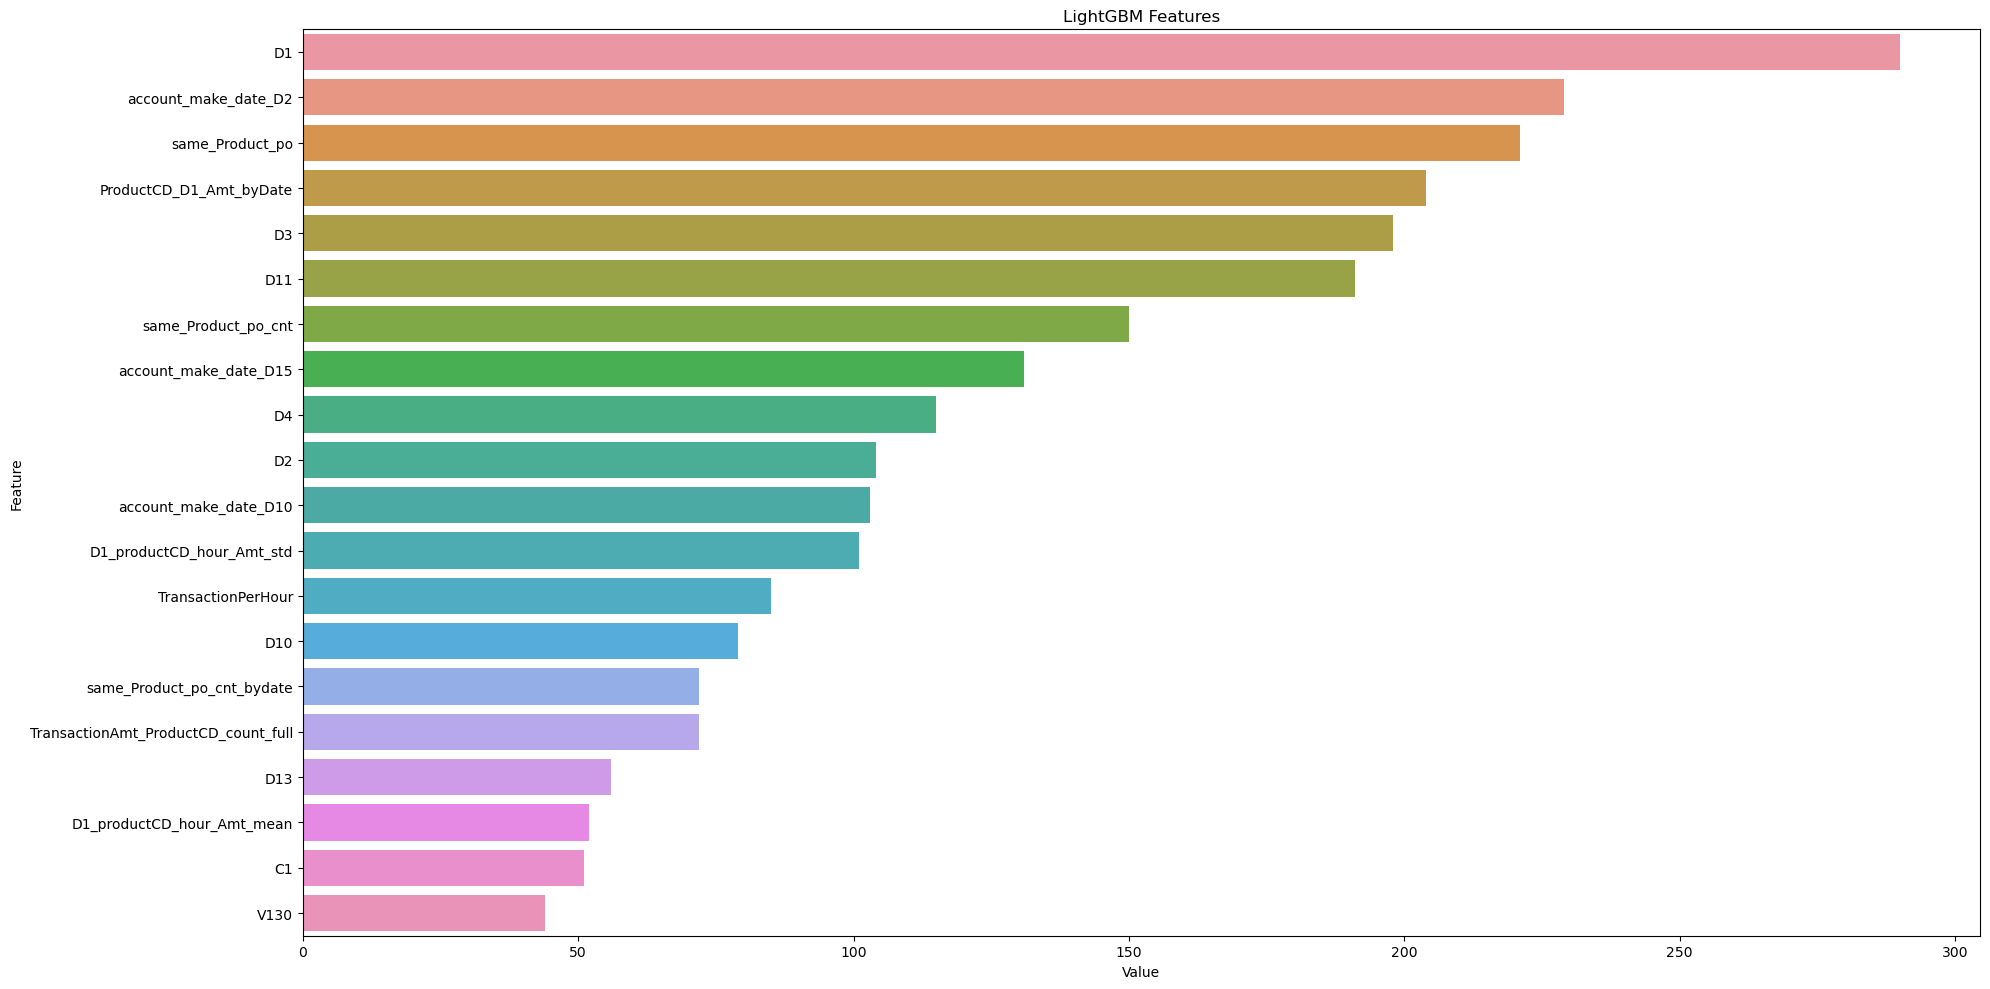

<Figure size 640x480 with 0 Axes>

In [65]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [66]:
feature_imp.sort_values(by='Value',ascending=False)

,Value,Feature
519,290,D1
518,229,account_make_date_D2
517,221,same_Product_po
516,204,ProductCD_D1_Amt_byDate
515,198,D3
...,...,...
166,0,V311
165,0,V31
164,0,V309
163,0,V306


#### ex)

In [56]:
len(train_df.columns)

567

In [58]:
len(features)

520

### ▶ lightgbm

In [106]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          # 'device_type' : 'gpu',
          # 'gpu_platform_id': 1,
          # 'gpu_device_id': 0,
          'random_state': 2024,
         }

In [98]:
# 시간정보 기반 피처 생성 : 2017년 1월을 기준으로 개월수
train_df['DT_M'] = (train_df['year']-2017)*12 + train_df['month'] 
test_df['DT_M'] = (test_df['year']-2017)*12 + test_df['month']

In [100]:
y = train_df['isFraud']
X = train_df[features].reset_index(drop=True)
test = test_df[features].reset_index(drop=True)

### ▶ group K fold

In [128]:
# %pip install pyopencl

   ---------------------------------------- 0.0/489.4 kB ? eta -:--:--
   ------------- -------------------------- 163.8/489.4 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 489.4/489.4 kB 5.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/88.1 kB ? eta -:--:--
   ---------------------------------------- 88.1/88.1 kB ? eta 0:00:00
   ---------------------------------------- 0.0/81.1 kB ? eta -:--:--
   ---------------------------------------- 81.1/81.1 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [130]:
# import pyopencl as cl

# platforms = cl.get_platforms()

# for platform in platforms:
#     print(f"Platform: {platform.name}")
#     devices = platform.get_devices()
#     for device in devices:
#         print(f"  Device: {device.name}, Type: {cl.device_type.to_string(device.type)}, ID: {device}")

Platform: Intel(R) OpenCL HD Graphics
  Device: Intel(R) UHD Graphics, Type: ALL | GPU, ID: <pyopencl.Device 'Intel(R) UHD Graphics' on 'Intel(R) OpenCL HD Graphics' at 0x1fb49b55cc0>
Platform: NVIDIA CUDA
  Device: NVIDIA GeForce RTX 4050 Laptop GPU, Type: ALL | GPU, ID: <pyopencl.Device 'NVIDIA GeForce RTX 4050 Laptop GPU' on 'NVIDIA CUDA' at 0x1fb64b00e20>


In [102]:
from time import time
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold
import lightgbm as lgb

NFOLD = 5
folds =  GroupKFold(n_splits=NFOLD)
split_groups = train_df['DT_M']

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
oofs = np.zeros(len(train_df))
preds = np.zeros(len(test_df))

In [108]:
training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y, groups = split_groups)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

    callbacks = [lgb.early_stopping(stopping_rounds=100), 
                 lgb.log_evaluation(period=100)]
    clf = lgb.train(params, trn_data, 
                    num_boost_round = 10000, 
                    valid_sets = [trn_data, val_data],
                    callbacks=callbacks)
    
    oofs[test_idx] = clf.predict(X.iloc[test_idx])
    preds += clf.predict(test)/NFOLD # test 행 수만큼 계산된 값을 미리 나눠서 더해주고 있음
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print("Total Validation: ", roc_auc_score(y, oofs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.956141	valid_1's auc: 0.882545
[200]	training's auc: 0.968361	valid_1's auc: 0.889509
[300]	training's auc: 0.978481	valid_1's auc: 0.896016
[400]	training's auc: 0.986187	valid_1's auc: 0.901136
[500]	training's auc: 0.991112	valid_1's auc: 0.905102
[600]	training's auc: 0.994444	valid_1's auc: 0.908291
[700]	training's auc: 0.996681	valid_1's auc: 0.911052
[800]	training's auc: 0.998095	valid_1's auc: 0.913045
[900]	training's auc: 0.998955	valid_1's auc: 0.91453
[1000]	training's auc: 0.99944	valid_1's auc: 0.915677
[1100]	training's auc: 0.999704	valid_1's auc: 0.916723
[1200]	training's auc: 0.999845	valid_1's auc: 0.917261
[1300]	training's auc: 0.999921	valid_1's auc: 0.917885
[1400]	training's auc: 0.999962	valid_1's auc: 0.918305
[1500]	training's auc: 0.999982	valid_1's auc: 0.918669
[1600]	training's auc: 0.999992	valid_1's auc: 0.919007
[1700]	training's auc: 0.999997	va

NameError: name 'roc_auc_score' is not defined

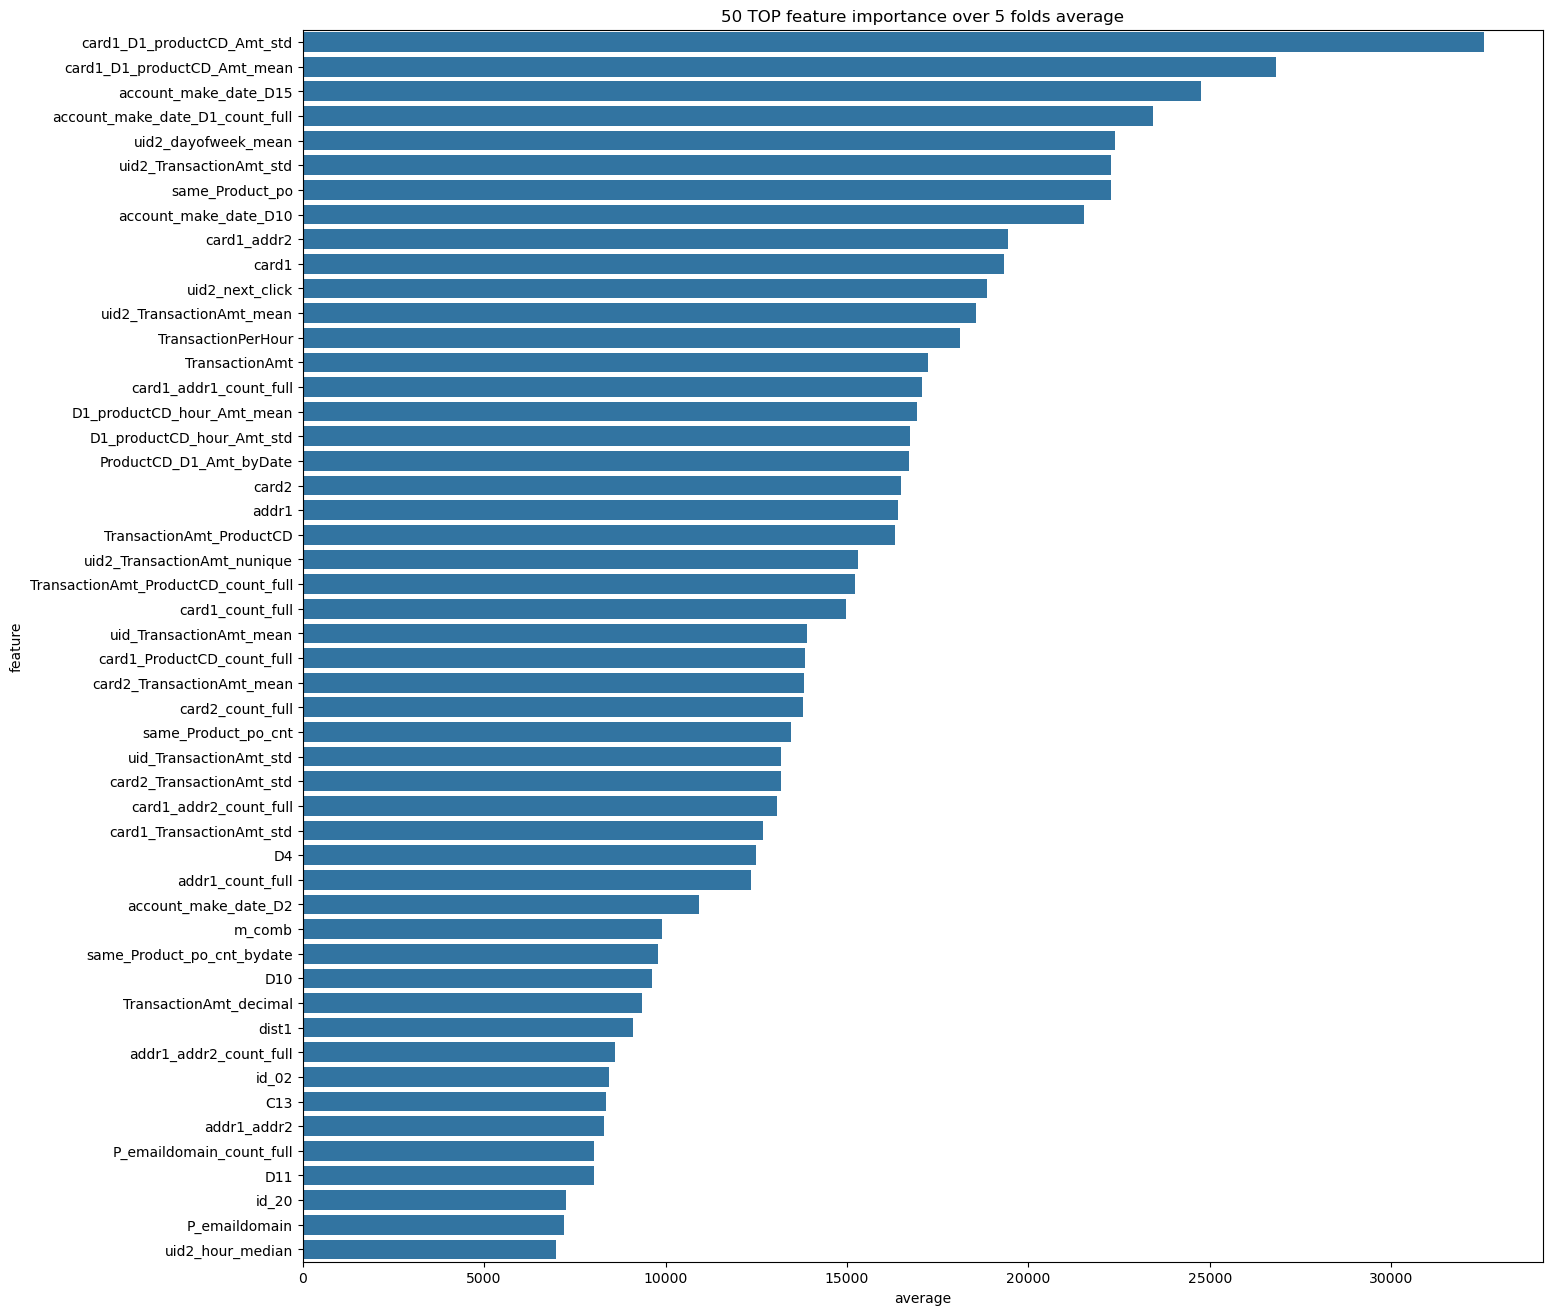

In [110]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [112]:
feature_importances.sort_values(by='average',ascending=False)[:50].to_csv('baseline_feature_importance.csv',index=False)

In [114]:
aucs

[0.920734410424542,
 0.9200393504097448,
 0.9528300090209789,
 0.9550723533891851,
 0.9455236350200746,
 0.9600634735005669]

In [122]:
oofs.shape

(590540,)

In [120]:
preds.shape

(506691,)

In [126]:
sub1 = pd.read_csv("./data/sample_submission.csv")
sub1['isFraud'] = preds
sub1.to_csv('BaseLine_IEEE_Model_9551_ka.csv', index=False)
# private score 0.928280

In [ ]:
X['']

#### ex)

In [71]:
feature_importances

,feature
0,TransactionAmt
1,card1
2,card2
3,addr1
4,addr2
...,...
515,same_Product_po
516,same_Product_po_cnt
517,same_Product_po_cnt_bydate
518,account_make_date_D1_count_full


In [73]:
for i in folds.split(X, y, groups = split_groups):
    print(i)

(array([137321, 137322, 137323, ..., 590537, 590538, 590539]), array([     0,      1,      2, ..., 137318, 137319, 137320]))
(array([     0,      1,      2, ..., 590537, 590538, 590539]), array([315927, 315928, 315929, ..., 417556, 417557, 417558]))
(array([     0,      1,      2, ..., 590537, 590538, 590539]), array([137321, 137322, 137323, ..., 229903, 229904, 229905]))
(array([     0,      1,      2, ..., 501211, 501212, 501213]), array([501214, 501215, 501216, ..., 590537, 590538, 590539]))
(array([     0,      1,      2, ..., 590537, 590538, 590539]), array([229906, 229907, 229908, ..., 501211, 501212, 501213]))
